In [1]:
!pip install -q torch_snippets
from torch_snippets import *
from torchvision.datasets import FashionMNIST
from torchvision import transforms

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.7/83.7 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.6/61.6 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 220.6/220.6 kB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.7/162.7 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 40.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 25.2 MB/s eta 0:00:00


In [2]:
import torch
device='cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
img_transforms=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]),
    transforms.Lambda(lambda x: x.to(device))
])

In [4]:
train_ds=FashionMNIST('/content/', transform=img_transforms, train=True, download=True)
val_ds=FashionMNIST('/content/', transform=img_transforms, train=False, download=True)

100%|██████████| 26.4M/26.4M [00:02<00:00, 11.6MB/s]


Extracting /content/FashionMNIST/raw/train-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 29.5k/29.5k [00:00<00:00, 199kB/s]


Extracting /content/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 4.42M/4.42M [00:01<00:00, 3.30MB/s]


Extracting /content/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /content/FashionMNIST/raw



100%|██████████| 5.15k/5.15k [00:00<00:00, 19.2MB/s]


Extracting /content/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /content/FashionMNIST/raw



In [5]:
from torch.utils.data import DataLoader
train_dl=DataLoader(train_ds, batch_size=128, shuffle=True)
val_dl=DataLoader(val_ds, batch_size=128, shuffle=True)

In [6]:
import torch.nn as nn
class ConvAutoEncoder(nn.Module):
  def __init__(self):
    super().__init__()
    self.encoder=nn.Sequential(
        nn.Conv2d(1, 32, 3, stride=3, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(2, stride=2),
        nn.Conv2d(32, 64, 3,  stride=2, padding=1),
        nn.ReLU(True),
        nn.MaxPool2d(2, stride=1)
    )

    self.decoder=nn.Sequential(
        nn.ConvTranspose2d(64, 32, 3, stride=2),
        nn.ReLU(True),
        nn.ConvTranspose2d(32, 16, 5, stride=3, padding=1),
        nn.ReLU(True),
        nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1),
        nn.Tanh()
    )

  def forward(self, x):
    x=self.encoder(x)
    x=self.decoder(x)
    return x

In [7]:
def train_batch(input, model, criterion, optimizer):
  model.train()
  optimizer.zero_grad()
  output=model(input)
  loss=criterion(output, input)
  loss.backward()
  optimizer.step()
  return loss

In [8]:
@torch.no_grad()
def validate_batch(input, model, criterion):
  model.eval()
  output=model(input)
  loss=criterion(output, input)
  return loss

In [9]:
model=ConvAutoEncoder().to(device)
criterion=nn.MSELoss()
optimizer=torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-5)

In [10]:
num_epochs = 10

train_losses = []
val_losses = []

for epoch in range(num_epochs):
  epoch_train_losses = []
  epoch_val_losses = []

  # Training loop
  N = len(train_dl)
  for ix, (data, _) in enumerate(train_dl):
    loss = train_batch(data, model, criterion, optimizer)
    epoch_train_losses.append(loss.item())  # Store loss as a number
    print(f"Epoch {epoch+1}/{num_epochs}, Batch {ix+1}/{N}, Training Loss: {loss.item():.4f}", end='\r')

  # Validation loop
  N = len(val_dl)
  for ix, (data, _) in enumerate(val_dl):
    loss = validate_batch(data, model, criterion)
    epoch_val_losses.append(loss.item())  # Store loss as a number
    print(f"Epoch {epoch+1}/{num_epochs}, Batch {ix+1}/{N}, Validation Loss: {loss.item():.4f}", end='\r')

  # Calculate and print average losses for the epoch
  avg_train_loss = sum(epoch_train_losses) / len(epoch_train_losses)
  avg_val_loss = sum(epoch_val_losses) / len(epoch_val_losses)

  train_losses.append(avg_train_loss)  # Store average losses for plotting later if needed
  val_losses.append(avg_val_loss)

  print(f"Epoch {epoch+1}/{num_epochs} - Avg. Training Loss: {avg_train_loss:.4f}, Avg. Validation Loss: {avg_val_loss:.4f}")

Epoch 1/10 - Avg. Training Loss: 0.1438, Avg. Validation Loss: 0.0776
Epoch 2/10 - Avg. Training Loss: 0.0680, Avg. Validation Loss: 0.0616
Epoch 3/10 - Avg. Training Loss: 0.0574, Avg. Validation Loss: 0.0545
Epoch 4/10 - Avg. Training Loss: 0.0520, Avg. Validation Loss: 0.0504
Epoch 5/10 - Avg. Training Loss: 0.0485, Avg. Validation Loss: 0.0475
Epoch 6/10 - Avg. Training Loss: 0.0459, Avg. Validation Loss: 0.0449
Epoch 7/10 - Avg. Training Loss: 0.0441, Avg. Validation Loss: 0.0435
Epoch 8/10 - Avg. Training Loss: 0.0425, Avg. Validation Loss: 0.0420
Epoch 9/10 - Avg. Training Loss: 0.0413, Avg. Validation Loss: 0.0410
Epoch 10/10 - Avg. Training Loss: 0.0403, Avg. Validation Loss: 0.0403


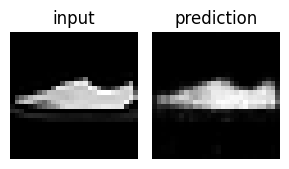

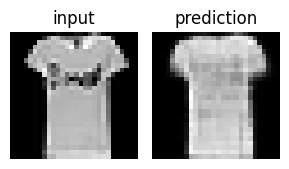

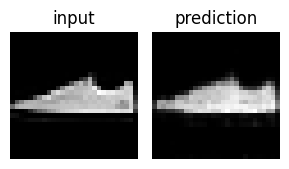

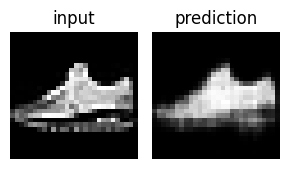

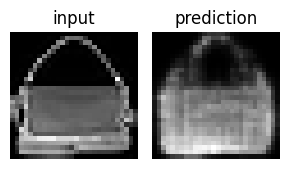

In [11]:
import matplotlib.pyplot as plt
for _ in range(5):
 ix = np.random.randint(len(val_ds))
 im, _ = val_ds[ix]
 _im = model(im[None])[0]
 fig, ax = plt.subplots(1, 2, figsize=(3,3))
 show(im[0], ax=ax[0], title='input')
 show(_im[0], ax=ax[1], title='prediction')
 plt.tight_layout()
 plt.show()

In [12]:
latent_vectors = []
classes = []


In [13]:


for im,clss in val_dl:
    latent_vectors.append(model.encoder(im).view(len(im),-1))
    classes.extend(clss)

In [14]:

latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy()

In [15]:
from sklearn.manifold import TSNE
tsne = TSNE(2)

In [16]:
clustered = tsne.fit_transform(latent_vectors)

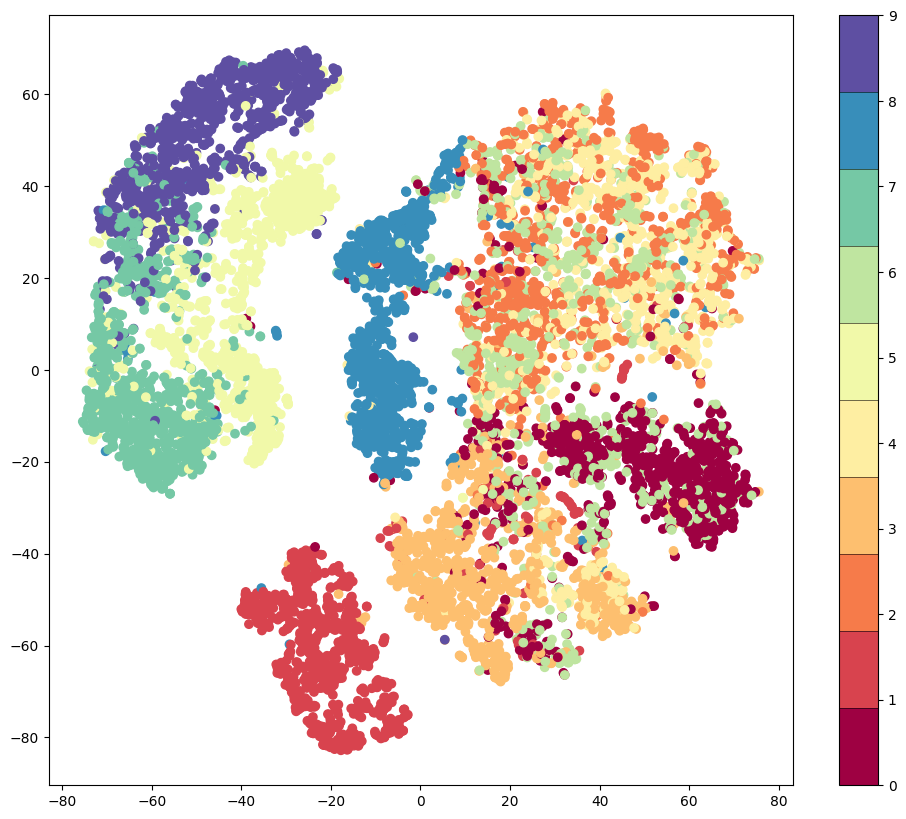

In [17]:
fig = plt.figure(figsize=(12,10))
cmap = plt.get_cmap('Spectral', 10)
plt.scatter(*zip(*clustered), c=classes, cmap=cmap)
plt.colorbar(drawedges=True)
